In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from glmtools.io.glm import GLMDataset, fix_event_locations
from glmtools.grid.clipping import QuadMeshSubset, QuadMeshPolySlicer

# Tests using generic geometry

In [4]:
# x = np.arange(5)
# y = np.arange(6)+10

x = np.arange(50)
y = np.arange(60)+10
X,Y=np.meshgrid(x,y)

vals = np.random.rand(X.shape[0]-1, X.shape[1]-1)
print(X.shape, Y.shape, vals.shape)

a_poly = [(.5,12), (1.7+2,13+1), (1.9+2,12.5+1), (.9+2, 11)]

N_polys = 1
polys = np.asarray([a_poly] * N_polys)
# polys += np.random.rand(N_polys,4,2) 
polys += .8*x.shape[0]*np.random.rand(N_polys)[:,None,None]

(60, 50) (60, 50) (59, 49)


In [5]:
print(X.T[:,0])
print(X.max())
print(polys.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
49
(1, 4, 2)


In [17]:
mesh = QuadMeshSubset(X, Y, n_neighbors=20)

slicer = QuadMeshPolySlicer(mesh)

chopped_polys, poly_areas = slicer.slice(polys)
# print(chopped_polys)

def gen_polys(chopped_polys):
    for (subquads, areas, (x_idxs, y_idxs)), total_area  in zip(chopped_polys, poly_areas):
        quad_fracs = slicer.quad_frac_from_poly_frac_area(
                        areas, total_area, x_idxs, y_idxs)

        for subquad, area, x_idx, y_idx, quad_area in zip(subquads, areas, x_idxs, y_idxs, quad_fracs):
            print('-------')
            print('subquad', subquad)
            print('frac_area, quad_frac_area', area, quad_area)
            print('idx', x_idx, y_idx)
            yield (subquad, area, (x_idx, y_idx))
        
good_polys = [p for p in gen_polys(chopped_polys)]

Calculating polygons from mesh ...
    ... constructing search tree ... be patient ...
    ... done.
-------
subquad [[ 12.  22.]
 [ 11.  22.]
 [ 11.  21.]
 [ 12.  21.]]
frac_area, quad_frac_area 0.222222222222 1.0
idx 11 11
-------
subquad [[ 12.83954252  22.        ]
 [ 12.          22.        ]
 [ 12.          21.        ]
 [ 12.43954252  21.        ]]
frac_area, quad_frac_area 0.142120559441 0.639542517485
idx 11 12
-------
subquad [[ 12.          22.64971407]
 [ 11.          22.02471407]
 [ 11.          22.        ]
 [ 12.          22.        ]]
frac_area, quad_frac_area 0.0749364608071 0.337214073632
idx 12 11
-------
subquad [[ 13.          22.40114371]
 [ 13.          23.        ]
 [ 12.56045748  23.        ]
 [ 12.          22.64971407]
 [ 12.          22.        ]
 [ 12.83954252  22.        ]]
frac_area, quad_frac_area 0.193257013579 0.869656561107
idx 12 12
-------
subquad [[ 12.          21.        ]
 [ 11.          21.        ]
 [ 11.          20.70447539]
 [ 12.          

[ 0.80416957  0.16505075  0.68818263  0.24525497  0.88775966  0.84250981
  0.9583024   0.70827513  0.95466722  0.38522405  0.50858863  0.73072589
  0.36152671]


(5, 15, 20, 30)

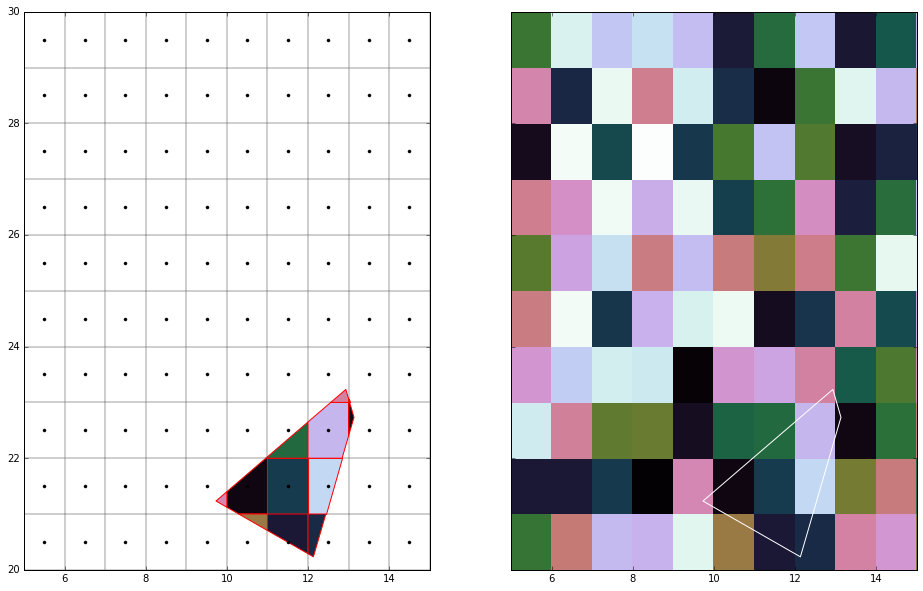

In [20]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig, axs = plt.subplots(1,2, figsize=(16,10), sharex=True, sharey=True)
ax = axs[0]
ax1 = axs[1]

vmin, vmax = 0, 1

# Chopped polys
pm = ax.pcolormesh(X, Y, vals*0, edgecolor='black', alpha=0.1, cmap='cubehelix_r', vmin=vmin, vmax=vmax)
ax.plot(mesh.X_ctr, mesh.Y_ctr, '.k')
patches = [Polygon(p, True) for p, area, ctrs in good_polys]
patch_coll = PatchCollection(patches, edgecolors='red', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_vals = np.asarray([vals[ctrs[0], ctrs[1]] for p, area, ctrs in good_polys])
print(patch_vals)
patch_coll.set_array(patch_vals)
ax.add_collection(patch_coll)

# Original polys
pm1 = ax1.pcolormesh(X,Y, vals, edgecolor='none', alpha=1.0, norm=pm.norm, cmap=pm.cmap)
patches = [Polygon(p, True) for p in polys]
patch_coll = PatchCollection(patches, edgecolors='red', facecolors='none', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_coll.set_array(np.fromiter((0 for p in polys), dtype=float))
ax1.add_collection(patch_coll)

# x0, x1, y0, y1 = X.min(), X.max(), Y.min(), Y.max()

# ax.axis((.4,1.5,10,16))
ax.axis((5,15,20,30))

In [31]:
for p in polys:
    print(np.asarray(p).mean(axis=0))

[ 23.51135896  35.89127162]
[ 12.73310993  25.06459235]
[ 13.92752945  25.67490451]
[  7.34950669  19.47587612]
[ 29.65059796  41.19790716]
[ 12.49748288  24.20219364]
[ 10.91466183  22.93670732]
[ 38.51420855  50.72453483]
[ 27.27100166  39.43128509]
[ 19.87239849  31.746935  ]


In [32]:
nq0, nq1 = mesh.quads.shape[0:2]

for i in range(nq0):
    for j in range(nq1):
        print(mesh.X_ctr[i, j], mesh.Y_ctr[i,j])
        print(mesh.quads[i,j,:,:])

0.5 10.5
[[  0.  10.]
 [  1.  10.]
 [  1.  11.]
 [  0.  11.]]
1.5 10.5
[[  1.  10.]
 [  2.  10.]
 [  2.  11.]
 [  1.  11.]]
2.5 10.5
[[  2.  10.]
 [  3.  10.]
 [  3.  11.]
 [  2.  11.]]
3.5 10.5
[[  3.  10.]
 [  4.  10.]
 [  4.  11.]
 [  3.  11.]]
4.5 10.5
[[  4.  10.]
 [  5.  10.]
 [  5.  11.]
 [  4.  11.]]
5.5 10.5
[[  5.  10.]
 [  6.  10.]
 [  6.  11.]
 [  5.  11.]]
6.5 10.5
[[  6.  10.]
 [  7.  10.]
 [  7.  11.]
 [  6.  11.]]
7.5 10.5
[[  7.  10.]
 [  8.  10.]
 [  8.  11.]
 [  7.  11.]]
8.5 10.5
[[  8.  10.]
 [  9.  10.]
 [  9.  11.]
 [  8.  11.]]
9.5 10.5
[[  9.  10.]
 [ 10.  10.]
 [ 10.  11.]
 [  9.  11.]]
10.5 10.5
[[ 10.  10.]
 [ 11.  10.]
 [ 11.  11.]
 [ 10.  11.]]
11.5 10.5
[[ 11.  10.]
 [ 12.  10.]
 [ 12.  11.]
 [ 11.  11.]]
12.5 10.5
[[ 12.  10.]
 [ 13.  10.]
 [ 13.  11.]
 [ 12.  11.]]
13.5 10.5
[[ 13.  10.]
 [ 14.  10.]
 [ 14.  11.]
 [ 13.  11.]]
14.5 10.5
[[ 14.  10.]
 [ 15.  10.]
 [ 15.  11.]
 [ 14.  11.]]
15.5 10.5
[[ 15.  10.]
 [ 16.  10.]
 [ 16.  11.]
 [ 15.  11.]]
16

19.5 15.5
[[ 19.  15.]
 [ 20.  15.]
 [ 20.  16.]
 [ 19.  16.]]
20.5 15.5
[[ 20.  15.]
 [ 21.  15.]
 [ 21.  16.]
 [ 20.  16.]]
21.5 15.5
[[ 21.  15.]
 [ 22.  15.]
 [ 22.  16.]
 [ 21.  16.]]
22.5 15.5
[[ 22.  15.]
 [ 23.  15.]
 [ 23.  16.]
 [ 22.  16.]]
23.5 15.5
[[ 23.  15.]
 [ 24.  15.]
 [ 24.  16.]
 [ 23.  16.]]
24.5 15.5
[[ 24.  15.]
 [ 25.  15.]
 [ 25.  16.]
 [ 24.  16.]]
25.5 15.5
[[ 25.  15.]
 [ 26.  15.]
 [ 26.  16.]
 [ 25.  16.]]
26.5 15.5
[[ 26.  15.]
 [ 27.  15.]
 [ 27.  16.]
 [ 26.  16.]]
27.5 15.5
[[ 27.  15.]
 [ 28.  15.]
 [ 28.  16.]
 [ 27.  16.]]
28.5 15.5
[[ 28.  15.]
 [ 29.  15.]
 [ 29.  16.]
 [ 28.  16.]]
29.5 15.5
[[ 29.  15.]
 [ 30.  15.]
 [ 30.  16.]
 [ 29.  16.]]
30.5 15.5
[[ 30.  15.]
 [ 31.  15.]
 [ 31.  16.]
 [ 30.  16.]]
31.5 15.5
[[ 31.  15.]
 [ 32.  15.]
 [ 32.  16.]
 [ 31.  16.]]
32.5 15.5
[[ 32.  15.]
 [ 33.  15.]
 [ 33.  16.]
 [ 32.  16.]]
33.5 15.5
[[ 33.  15.]
 [ 34.  15.]
 [ 34.  16.]
 [ 33.  16.]]
34.5 15.5
[[ 34.  15.]
 [ 35.  15.]
 [ 35.  16.]
 [ 34.

 [  7.  22.]]
8.5 21.5
[[  8.  21.]
 [  9.  21.]
 [  9.  22.]
 [  8.  22.]]
9.5 21.5
[[  9.  21.]
 [ 10.  21.]
 [ 10.  22.]
 [  9.  22.]]
10.5 21.5
[[ 10.  21.]
 [ 11.  21.]
 [ 11.  22.]
 [ 10.  22.]]
11.5 21.5
[[ 11.  21.]
 [ 12.  21.]
 [ 12.  22.]
 [ 11.  22.]]
12.5 21.5
[[ 12.  21.]
 [ 13.  21.]
 [ 13.  22.]
 [ 12.  22.]]
13.5 21.5
[[ 13.  21.]
 [ 14.  21.]
 [ 14.  22.]
 [ 13.  22.]]
14.5 21.5
[[ 14.  21.]
 [ 15.  21.]
 [ 15.  22.]
 [ 14.  22.]]
15.5 21.5
[[ 15.  21.]
 [ 16.  21.]
 [ 16.  22.]
 [ 15.  22.]]
16.5 21.5
[[ 16.  21.]
 [ 17.  21.]
 [ 17.  22.]
 [ 16.  22.]]
17.5 21.5
[[ 17.  21.]
 [ 18.  21.]
 [ 18.  22.]
 [ 17.  22.]]
18.5 21.5
[[ 18.  21.]
 [ 19.  21.]
 [ 19.  22.]
 [ 18.  22.]]
19.5 21.5
[[ 19.  21.]
 [ 20.  21.]
 [ 20.  22.]
 [ 19.  22.]]
20.5 21.5
[[ 20.  21.]
 [ 21.  21.]
 [ 21.  22.]
 [ 20.  22.]]
21.5 21.5
[[ 21.  21.]
 [ 22.  21.]
 [ 22.  22.]
 [ 21.  22.]]
22.5 21.5
[[ 22.  21.]
 [ 23.  21.]
 [ 23.  22.]
 [ 22.  22.]]
23.5 21.5
[[ 23.  21.]
 [ 24.  21.]
 [ 24. 

 [ 23.  29.]]
24.5 28.5
[[ 24.  28.]
 [ 25.  28.]
 [ 25.  29.]
 [ 24.  29.]]
25.5 28.5
[[ 25.  28.]
 [ 26.  28.]
 [ 26.  29.]
 [ 25.  29.]]
26.5 28.5
[[ 26.  28.]
 [ 27.  28.]
 [ 27.  29.]
 [ 26.  29.]]
27.5 28.5
[[ 27.  28.]
 [ 28.  28.]
 [ 28.  29.]
 [ 27.  29.]]
28.5 28.5
[[ 28.  28.]
 [ 29.  28.]
 [ 29.  29.]
 [ 28.  29.]]
29.5 28.5
[[ 29.  28.]
 [ 30.  28.]
 [ 30.  29.]
 [ 29.  29.]]
30.5 28.5
[[ 30.  28.]
 [ 31.  28.]
 [ 31.  29.]
 [ 30.  29.]]
31.5 28.5
[[ 31.  28.]
 [ 32.  28.]
 [ 32.  29.]
 [ 31.  29.]]
32.5 28.5
[[ 32.  28.]
 [ 33.  28.]
 [ 33.  29.]
 [ 32.  29.]]
33.5 28.5
[[ 33.  28.]
 [ 34.  28.]
 [ 34.  29.]
 [ 33.  29.]]
34.5 28.5
[[ 34.  28.]
 [ 35.  28.]
 [ 35.  29.]
 [ 34.  29.]]
35.5 28.5
[[ 35.  28.]
 [ 36.  28.]
 [ 36.  29.]
 [ 35.  29.]]
36.5 28.5
[[ 36.  28.]
 [ 37.  28.]
 [ 37.  29.]
 [ 36.  29.]]
37.5 28.5
[[ 37.  28.]
 [ 38.  28.]
 [ 38.  29.]
 [ 37.  29.]]
38.5 28.5
[[ 38.  28.]
 [ 39.  28.]
 [ 39.  29.]
 [ 38.  29.]]
39.5 28.5
[[ 39.  28.]
 [ 40.  28.]
 [ 40

12.5 36.5
[[ 12.  36.]
 [ 13.  36.]
 [ 13.  37.]
 [ 12.  37.]]
13.5 36.5
[[ 13.  36.]
 [ 14.  36.]
 [ 14.  37.]
 [ 13.  37.]]
14.5 36.5
[[ 14.  36.]
 [ 15.  36.]
 [ 15.  37.]
 [ 14.  37.]]
15.5 36.5
[[ 15.  36.]
 [ 16.  36.]
 [ 16.  37.]
 [ 15.  37.]]
16.5 36.5
[[ 16.  36.]
 [ 17.  36.]
 [ 17.  37.]
 [ 16.  37.]]
17.5 36.5
[[ 17.  36.]
 [ 18.  36.]
 [ 18.  37.]
 [ 17.  37.]]
18.5 36.5
[[ 18.  36.]
 [ 19.  36.]
 [ 19.  37.]
 [ 18.  37.]]
19.5 36.5
[[ 19.  36.]
 [ 20.  36.]
 [ 20.  37.]
 [ 19.  37.]]
20.5 36.5
[[ 20.  36.]
 [ 21.  36.]
 [ 21.  37.]
 [ 20.  37.]]
21.5 36.5
[[ 21.  36.]
 [ 22.  36.]
 [ 22.  37.]
 [ 21.  37.]]
22.5 36.5
[[ 22.  36.]
 [ 23.  36.]
 [ 23.  37.]
 [ 22.  37.]]
23.5 36.5
[[ 23.  36.]
 [ 24.  36.]
 [ 24.  37.]
 [ 23.  37.]]
24.5 36.5
[[ 24.  36.]
 [ 25.  36.]
 [ 25.  37.]
 [ 24.  37.]]
25.5 36.5
[[ 25.  36.]
 [ 26.  36.]
 [ 26.  37.]
 [ 25.  37.]]
26.5 36.5
[[ 26.  36.]
 [ 27.  36.]
 [ 27.  37.]
 [ 26.  37.]]
27.5 36.5
[[ 27.  36.]
 [ 28.  36.]
 [ 28.  37.]
 [ 27.

 [ 37.  46.]]
38.5 45.5
[[ 38.  45.]
 [ 39.  45.]
 [ 39.  46.]
 [ 38.  46.]]
39.5 45.5
[[ 39.  45.]
 [ 40.  45.]
 [ 40.  46.]
 [ 39.  46.]]
40.5 45.5
[[ 40.  45.]
 [ 41.  45.]
 [ 41.  46.]
 [ 40.  46.]]
41.5 45.5
[[ 41.  45.]
 [ 42.  45.]
 [ 42.  46.]
 [ 41.  46.]]
42.5 45.5
[[ 42.  45.]
 [ 43.  45.]
 [ 43.  46.]
 [ 42.  46.]]
43.5 45.5
[[ 43.  45.]
 [ 44.  45.]
 [ 44.  46.]
 [ 43.  46.]]
44.5 45.5
[[ 44.  45.]
 [ 45.  45.]
 [ 45.  46.]
 [ 44.  46.]]
45.5 45.5
[[ 45.  45.]
 [ 46.  45.]
 [ 46.  46.]
 [ 45.  46.]]
46.5 45.5
[[ 46.  45.]
 [ 47.  45.]
 [ 47.  46.]
 [ 46.  46.]]
47.5 45.5
[[ 47.  45.]
 [ 48.  45.]
 [ 48.  46.]
 [ 47.  46.]]
48.5 45.5
[[ 48.  45.]
 [ 49.  45.]
 [ 49.  46.]
 [ 48.  46.]]
0.5 46.5
[[  0.  46.]
 [  1.  46.]
 [  1.  47.]
 [  0.  47.]]
1.5 46.5
[[  1.  46.]
 [  2.  46.]
 [  2.  47.]
 [  1.  47.]]
2.5 46.5
[[  2.  46.]
 [  3.  46.]
 [  3.  47.]
 [  2.  47.]]
3.5 46.5
[[  3.  46.]
 [  4.  46.]
 [  4.  47.]
 [  3.  47.]]
4.5 46.5
[[  4.  46.]
 [  5.  46.]
 [  5.  47

14.5 55.5
[[ 14.  55.]
 [ 15.  55.]
 [ 15.  56.]
 [ 14.  56.]]
15.5 55.5
[[ 15.  55.]
 [ 16.  55.]
 [ 16.  56.]
 [ 15.  56.]]
16.5 55.5
[[ 16.  55.]
 [ 17.  55.]
 [ 17.  56.]
 [ 16.  56.]]
17.5 55.5
[[ 17.  55.]
 [ 18.  55.]
 [ 18.  56.]
 [ 17.  56.]]
18.5 55.5
[[ 18.  55.]
 [ 19.  55.]
 [ 19.  56.]
 [ 18.  56.]]
19.5 55.5
[[ 19.  55.]
 [ 20.  55.]
 [ 20.  56.]
 [ 19.  56.]]
20.5 55.5
[[ 20.  55.]
 [ 21.  55.]
 [ 21.  56.]
 [ 20.  56.]]
21.5 55.5
[[ 21.  55.]
 [ 22.  55.]
 [ 22.  56.]
 [ 21.  56.]]
22.5 55.5
[[ 22.  55.]
 [ 23.  55.]
 [ 23.  56.]
 [ 22.  56.]]
23.5 55.5
[[ 23.  55.]
 [ 24.  55.]
 [ 24.  56.]
 [ 23.  56.]]
24.5 55.5
[[ 24.  55.]
 [ 25.  55.]
 [ 25.  56.]
 [ 24.  56.]]
25.5 55.5
[[ 25.  55.]
 [ 26.  55.]
 [ 26.  56.]
 [ 25.  56.]]
26.5 55.5
[[ 26.  55.]
 [ 27.  55.]
 [ 27.  56.]
 [ 26.  56.]]
27.5 55.5
[[ 27.  55.]
 [ 28.  55.]
 [ 28.  56.]
 [ 27.  56.]]
28.5 55.5
[[ 28.  55.]
 [ 29.  55.]
 [ 29.  56.]
 [ 28.  56.]]
29.5 55.5
[[ 29.  55.]
 [ 30.  55.]
 [ 30.  56.]
 [ 29.

16.5 64.5
[[ 16.  64.]
 [ 17.  64.]
 [ 17.  65.]
 [ 16.  65.]]
17.5 64.5
[[ 17.  64.]
 [ 18.  64.]
 [ 18.  65.]
 [ 17.  65.]]
18.5 64.5
[[ 18.  64.]
 [ 19.  64.]
 [ 19.  65.]
 [ 18.  65.]]
19.5 64.5
[[ 19.  64.]
 [ 20.  64.]
 [ 20.  65.]
 [ 19.  65.]]
20.5 64.5
[[ 20.  64.]
 [ 21.  64.]
 [ 21.  65.]
 [ 20.  65.]]
21.5 64.5
[[ 21.  64.]
 [ 22.  64.]
 [ 22.  65.]
 [ 21.  65.]]
22.5 64.5
[[ 22.  64.]
 [ 23.  64.]
 [ 23.  65.]
 [ 22.  65.]]
23.5 64.5
[[ 23.  64.]
 [ 24.  64.]
 [ 24.  65.]
 [ 23.  65.]]
24.5 64.5
[[ 24.  64.]
 [ 25.  64.]
 [ 25.  65.]
 [ 24.  65.]]
25.5 64.5
[[ 25.  64.]
 [ 26.  64.]
 [ 26.  65.]
 [ 25.  65.]]
26.5 64.5
[[ 26.  64.]
 [ 27.  64.]
 [ 27.  65.]
 [ 26.  65.]]
27.5 64.5
[[ 27.  64.]
 [ 28.  64.]
 [ 28.  65.]
 [ 27.  65.]]
28.5 64.5
[[ 28.  64.]
 [ 29.  64.]
 [ 29.  65.]
 [ 28.  65.]]
29.5 64.5
[[ 29.  64.]
 [ 30.  64.]
 [ 30.  65.]
 [ 29.  65.]]
30.5 64.5
[[ 30.  64.]
 [ 31.  64.]
 [ 31.  65.]
 [ 30.  65.]]
31.5 64.5
[[ 31.  64.]
 [ 32.  64.]
 [ 32.  65.]
 [ 31.